# Part 1: Storing and Retrieving Data — CSV vs Parquet Benchmarking

**CSIS 4260 — Assignment 1**  
**Author:** Desmond Chua  

## Objective
This notebook evaluates whether to keep the S&P 500 stock price dataset in **CSV format** or convert it to **Parquet format** with various compression schemes. We benchmark read/write performance and file sizes at **1x, 10x, and 100x** data scales to make a recommendation for each scale.

## What is CSV vs Parquet?

- **CSV (Comma-Separated Values):** A simple text-based format where each row is stored as a line of text. It's human-readable and universally compatible, but slow to read for large files because the entire file must be parsed line by line.

- **Parquet:** A columnar binary storage format designed for analytics workloads. Instead of storing data row by row, it stores data column by column. This makes it much faster for analytical queries (e.g., "give me all the closing prices") because it only reads the columns needed. Parquet also supports built-in compression.

## Compression Schemes Tested
- **Snappy:** Fast compression/decompression with moderate compression ratio. Designed for speed.
- **Gzip:** Higher compression ratio but slower. Good for archival storage.
- **Brotli:** Best compression ratio but slowest. Good when storage space is critical.
- **Uncompressed Parquet:** No compression — tests the benefit of columnar format alone.

## 1. Setup and Data Loading
First, we import all necessary libraries and load the dataset.

In [1]:
# Import required libraries
import pandas as pd          # Data manipulation library
import numpy as np           # Numerical operations
import os                    # File system operations (checking file sizes)
import time                  # Timing operations
import timeit                # More accurate timing with multiple runs
import matplotlib.pyplot as plt  # Creating charts
import warnings
warnings.filterwarnings('ignore')  # Suppress unnecessary warnings

# Set plot style for cleaner looking charts
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Load the original CSV dataset
# The dataset contains daily stock prices for 505 S&P 500 companies
csv_path = '../data/all_stocks_5yr.csv'

df = pd.read_csv(csv_path)

# Display basic information about the dataset
print(f"Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"\nColumn types:")
print(df.dtypes)
print(f"\nFirst 5 rows:")
df.head()

Dataset shape: 619,040 rows × 7 columns

Column types:
date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
name       object
dtype: object

First 5 rows:


,date,open,high,low,close,volume,name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [3]:
# Quick dataset overview
# How many unique companies are in the dataset?
print(f"Number of unique companies: {df['name'].nunique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
print(f"\nBasic statistics:")
df.describe()

Number of unique companies: 505
Date range: 2013-02-08 to 2018-02-07

Memory usage: 89.21 MB

Basic statistics:


,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023334,83.778311,82.256096,83.043763,4.321823e+06
std,97.378769,98.207519,96.507421,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220000,40.620000,39.830000,40.245000,1.070320e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082094e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284509e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


## 2. Benchmark Functions

We create reusable functions to measure:
1. **Write time** — how long it takes to save data to disk
2. **Read time** — how long it takes to load data from disk
3. **File size** — how much disk space the file uses

We use `timeit` with multiple runs for more accurate measurements, as a single run can be affected by system activity.

In [4]:
def benchmark_write(df, file_path, file_format, compression=None, num_runs=3):
    """
    Measures how long it takes to WRITE a dataframe to disk.
    
    Parameters:
    - df: the pandas DataFrame to write
    - file_path: where to save the file
    - file_format: 'csv' or 'parquet'
    - compression: compression scheme (None, 'snappy', 'gzip', 'brotli')
    - num_runs: number of times to run for averaging
    
    Returns: average write time in seconds
    """
    times = []
    for _ in range(num_runs):
        start = time.time()
        if file_format == 'csv':
            df.to_csv(file_path, index=False)
        elif file_format == 'parquet':
            df.to_parquet(file_path, engine='pyarrow', compression=compression, index=False)
        end = time.time()
        times.append(end - start)
    
    return np.mean(times)


def benchmark_read(file_path, file_format, num_runs=3):
    """
    Measures how long it takes to READ a file from disk into a DataFrame.
    
    Parameters:
    - file_path: path to the file to read
    - file_format: 'csv' or 'parquet'
    - num_runs: number of times to run for averaging
    
    Returns: average read time in seconds
    """
    times = []
    for _ in range(num_runs):
        start = time.time()
        if file_format == 'csv':
            pd.read_csv(file_path)
        elif file_format == 'parquet':
            pd.read_parquet(file_path, engine='pyarrow')
        end = time.time()
        times.append(end - start)
    
    return np.mean(times)


def get_file_size_mb(file_path):
    """
    Returns the file size in megabytes (MB).
    os.path.getsize() returns bytes, so we divide by 1024^2 to get MB.
    """
    return os.path.getsize(file_path) / (1024 ** 2)


print("Benchmark functions defined successfully!")

Benchmark functions defined successfully!


## 3. Benchmarking at 1x Scale (Original Dataset — 619,040 rows)

We first test all formats at the original data size to establish a baseline.

In [5]:
# Define all the formats we want to test
# Each entry: (label, file_path, format, compression)
formats = [
    ('CSV',                  '../data/benchmark_1x.csv',              'csv',     None),
    ('Parquet (No Compress)','../data/benchmark_1x_none.parquet',     'parquet', None),
    ('Parquet (Snappy)',     '../data/benchmark_1x_snappy.parquet',   'parquet', 'snappy'),
    ('Parquet (Gzip)',       '../data/benchmark_1x_gzip.parquet',     'parquet', 'gzip'),
    ('Parquet (Brotli)',     '../data/benchmark_1x_brotli.parquet',   'parquet', 'brotli'),
]

# Run benchmarks at 1x scale
print("Running 1x scale benchmarks (619,040 rows)...")
print("=" * 70)

results_1x = []
for label, path, fmt, comp in formats:
    # Measure write time
    write_time = benchmark_write(df, path, fmt, comp)
    
    # Measure read time
    read_time = benchmark_read(path, fmt)
    
    # Measure file size
    file_size = get_file_size_mb(path)
    
    results_1x.append({
        'Format': label,
        'Write Time (s)': round(write_time, 3),
        'Read Time (s)': round(read_time, 3),
        'File Size (MB)': round(file_size, 2)
    })
    
    print(f"{label:25s} | Write: {write_time:.3f}s | Read: {read_time:.3f}s | Size: {file_size:.2f} MB")

# Convert results to a DataFrame for easy viewing
df_results_1x = pd.DataFrame(results_1x)
print("\n1x Scale Results Summary:")
df_results_1x

Running 1x scale benchmarks (619,040 rows)...
CSV                       | Write: 6.979s | Read: 1.390s | Size: 28.80 MB
Parquet (No Compress)     | Write: 1.716s | Read: 2.335s | Size: 12.54 MB
Parquet (Snappy)          | Write: 0.409s | Read: 0.128s | Size: 10.03 MB
Parquet (Gzip)            | Write: 10.497s | Read: 0.118s | Size: 8.27 MB
Parquet (Brotli)          | Write: 3.385s | Read: 0.145s | Size: 7.89 MB

1x Scale Results Summary:


,Format,Write Time (s),Read Time (s),File Size (MB)
0,CSV,6.979,1.390,28.80
1,Parquet (No Compress),1.716,2.335,12.54
2,Parquet (Snappy),0.409,0.128,10.03
3,Parquet (Gzip),10.497,0.118,8.27
4,Parquet (Brotli),3.385,0.145,7.89


## 4. Benchmarking at 10x Scale (~6.2 million rows)

We simulate 10x data growth by duplicating the original dataset 10 times. This represents a realistic scenario where the dataset grows over time (e.g., more years of stock data or more companies).

In [6]:
# Create 10x dataset by concatenating the original 10 times
# ignore_index=True resets the row index to avoid duplicate indices
print("Creating 10x dataset...")
df_10x = pd.concat([df] * 10, ignore_index=True)
print(f"10x dataset shape: {df_10x.shape[0]:,} rows × {df_10x.shape[1]} columns")
print(f"Memory usage: {df_10x.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Creating 10x dataset...
10x dataset shape: 6,190,400 rows × 7 columns
Memory usage: 892.06 MB


In [7]:
# Run benchmarks at 10x scale
formats_10x = [
    ('CSV',                  '../data/benchmark_10x.csv',              'csv',     None),
    ('Parquet (No Compress)','../data/benchmark_10x_none.parquet',     'parquet', None),
    ('Parquet (Snappy)',     '../data/benchmark_10x_snappy.parquet',   'parquet', 'snappy'),
    ('Parquet (Gzip)',       '../data/benchmark_10x_gzip.parquet',     'parquet', 'gzip'),
    ('Parquet (Brotli)',     '../data/benchmark_10x_brotli.parquet',   'parquet', 'brotli'),
]

print("Running 10x scale benchmarks (6,190,400 rows)...")
print("=" * 70)

results_10x = []
for label, path, fmt, comp in formats_10x:
    write_time = benchmark_write(df_10x, path, fmt, comp)
    read_time = benchmark_read(path, fmt)
    file_size = get_file_size_mb(path)
    
    results_10x.append({
        'Format': label,
        'Write Time (s)': round(write_time, 3),
        'Read Time (s)': round(read_time, 3),
        'File Size (MB)': round(file_size, 2)
    })
    
    print(f"{label:25s} | Write: {write_time:.3f}s | Read: {read_time:.3f}s | Size: {file_size:.2f} MB")

df_results_10x = pd.DataFrame(results_10x)
print("\n10x Scale Results Summary:")
df_results_10x

Running 10x scale benchmarks (6,190,400 rows)...
CSV                       | Write: 49.761s | Read: 7.595s | Size: 288.01 MB
Parquet (No Compress)     | Write: 6.150s | Read: 1.657s | Size: 116.91 MB
Parquet (Snappy)          | Write: 6.565s | Read: 1.841s | Size: 94.92 MB
Parquet (Gzip)            | Write: 121.673s | Read: 2.129s | Size: 78.74 MB
Parquet (Brotli)          | Write: 56.126s | Read: 2.344s | Size: 75.17 MB

10x Scale Results Summary:


,Format,Write Time (s),Read Time (s),File Size (MB)
0,CSV,49.761,7.595,288.01
1,Parquet (No Compress),6.150,1.657,116.91
2,Parquet (Snappy),6.565,1.841,94.92
3,Parquet (Gzip),121.673,2.129,78.74
4,Parquet (Brotli),56.126,2.344,75.17


## 5. Benchmarking at 100x Scale (~62 million rows)

We simulate 100x data growth. At this scale, the performance differences between CSV and Parquet become very significant. This is where the choice of storage format really matters.

In [8]:
# Create 100x dataset
# NOTE: This will use significant memory (~4-5 GB RAM)
print("Creating 100x dataset (this may take a moment)...")
df_100x = pd.concat([df] * 100, ignore_index=True)
print(f"100x dataset shape: {df_100x.shape[0]:,} rows × {df_100x.shape[1]} columns")
print(f"Memory usage: {df_100x.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

Creating 100x dataset (this may take a moment)...
100x dataset shape: 61,904,000 rows × 7 columns
Memory usage: 8920.60 MB


In [9]:
# Run benchmarks at 100x scale
# Using fewer runs (2) at this scale because each run takes much longer
formats_100x = [
    ('CSV',                  '../data/benchmark_100x.csv',              'csv',     None),
    ('Parquet (No Compress)','../data/benchmark_100x_none.parquet',     'parquet', None),
    ('Parquet (Snappy)',     '../data/benchmark_100x_snappy.parquet',   'parquet', 'snappy'),
    ('Parquet (Gzip)',       '../data/benchmark_100x_gzip.parquet',     'parquet', 'gzip'),
    ('Parquet (Brotli)',     '../data/benchmark_100x_brotli.parquet',   'parquet', 'brotli'),
]

print("Running 100x scale benchmarks (61,904,000 rows)...")
print("This will take several minutes — please be patient!")
print("=" * 70)

results_100x = []
for label, path, fmt, comp in formats_100x:
    write_time = benchmark_write(df_100x, path, fmt, comp, num_runs=2)
    read_time = benchmark_read(path, fmt, num_runs=2)
    file_size = get_file_size_mb(path)
    
    results_100x.append({
        'Format': label,
        'Write Time (s)': round(write_time, 3),
        'Read Time (s)': round(read_time, 3),
        'File Size (MB)': round(file_size, 2)
    })
    
    print(f"{label:25s} | Write: {write_time:.3f}s | Read: {read_time:.3f}s | Size: {file_size:.2f} MB")

df_results_100x = pd.DataFrame(results_100x)
print("\n100x Scale Results Summary:")
df_results_100x

Running 100x scale benchmarks (61,904,000 rows)...
This will take several minutes — please be patient!
CSV                       | Write: 993.224s | Read: 235.104s | Size: 2880.05 MB
Parquet (No Compress)     | Write: 152.367s | Read: 69.844s | Size: 1166.98 MB
Parquet (Snappy)          | Write: 523.101s | Read: 45.018s | Size: 947.92 MB
Parquet (Gzip)            | Write: 1926.712s | Read: 38.395s | Size: 785.89 MB
Parquet (Brotli)          | Write: 1139.907s | Read: 50.606s | Size: 750.27 MB

100x Scale Results Summary:


,Format,Write Time (s),Read Time (s),File Size (MB)
0,CSV,993.224,235.104,2880.05
1,Parquet (No Compress),152.367,69.844,1166.98
2,Parquet (Snappy),523.101,45.018,947.92
3,Parquet (Gzip),1926.712,38.395,785.89
4,Parquet (Brotli),1139.907,50.606,750.27


## 6. Combined Comparison Tables

Let's combine all results into a single comparison view to make the performance differences clear across all scales.

In [10]:
# Combine all results into one table with a 'Scale' column
df_results_1x['Scale'] = '1x'
df_results_10x['Scale'] = '10x'
df_results_100x['Scale'] = '100x'

df_all_results = pd.concat([df_results_1x, df_results_10x, df_results_100x], ignore_index=True)

# Reorder columns for readability
df_all_results = df_all_results[['Scale', 'Format', 'Write Time (s)', 'Read Time (s)', 'File Size (MB)']]

print("Complete Benchmark Results Across All Scales")
print("=" * 80)
df_all_results

Complete Benchmark Results Across All Scales


,Scale,Format,Write Time (s),Read Time (s),File Size (MB)
0,1x,CSV,6.979,1.390,28.80
1,1x,Parquet (No Compress),1.716,2.335,12.54
2,1x,Parquet (Snappy),0.409,0.128,10.03
3,1x,Parquet (Gzip),10.497,0.118,8.27
4,1x,Parquet (Brotli),3.385,0.145,7.89
5,10x,CSV,49.761,7.595,288.01
6,10x,Parquet (No Compress),6.150,1.657,116.91
7,10x,Parquet (Snappy),6.565,1.841,94.92
8,10x,Parquet (Gzip),121.673,2.129,78.74
9,10x,Parquet (Brotli),56.126,2.344,75.17


In [11]:
# Calculate speedup ratios: how much faster is each Parquet format vs CSV?
# This helps quantify the performance improvement

for scale, group in df_all_results.groupby('Scale'):
    csv_read = group[group['Format'] == 'CSV']['Read Time (s)'].values[0]
    csv_write = group[group['Format'] == 'CSV']['Write Time (s)'].values[0]
    csv_size = group[group['Format'] == 'CSV']['File Size (MB)'].values[0]
    
    print(f"\n{'='*60}")
    print(f"Speedup vs CSV at {scale} scale:")
    print(f"{'='*60}")
    
    for _, row in group.iterrows():
        if row['Format'] != 'CSV':
            read_speedup = csv_read / row['Read Time (s)'] if row['Read Time (s)'] > 0 else 0
            write_speedup = csv_write / row['Write Time (s)'] if row['Write Time (s)'] > 0 else 0
            size_ratio = csv_size / row['File Size (MB)'] if row['File Size (MB)'] > 0 else 0
            print(f"{row['Format']:25s} | Read: {read_speedup:.1f}x faster | Write: {write_speedup:.1f}x faster | Size: {size_ratio:.1f}x smaller")


Speedup vs CSV at 100x scale:
Parquet (No Compress)     | Read: 3.4x faster | Write: 6.5x faster | Size: 2.5x smaller
Parquet (Snappy)          | Read: 5.2x faster | Write: 1.9x faster | Size: 3.0x smaller
Parquet (Gzip)            | Read: 6.1x faster | Write: 0.5x faster | Size: 3.7x smaller
Parquet (Brotli)          | Read: 4.6x faster | Write: 0.9x faster | Size: 3.8x smaller

Speedup vs CSV at 10x scale:
Parquet (No Compress)     | Read: 4.6x faster | Write: 8.1x faster | Size: 2.5x smaller
Parquet (Snappy)          | Read: 4.1x faster | Write: 7.6x faster | Size: 3.0x smaller
Parquet (Gzip)            | Read: 3.6x faster | Write: 0.4x faster | Size: 3.7x smaller
Parquet (Brotli)          | Read: 3.2x faster | Write: 0.9x faster | Size: 3.8x smaller

Speedup vs CSV at 1x scale:
Parquet (No Compress)     | Read: 0.6x faster | Write: 4.1x faster | Size: 2.3x smaller
Parquet (Snappy)          | Read: 10.9x faster | Write: 17.1x faster | Size: 2.9x smaller
Parquet (Gzip)            | 

## 7. Visualization

Charts make it much easier to see the performance differences at a glance.

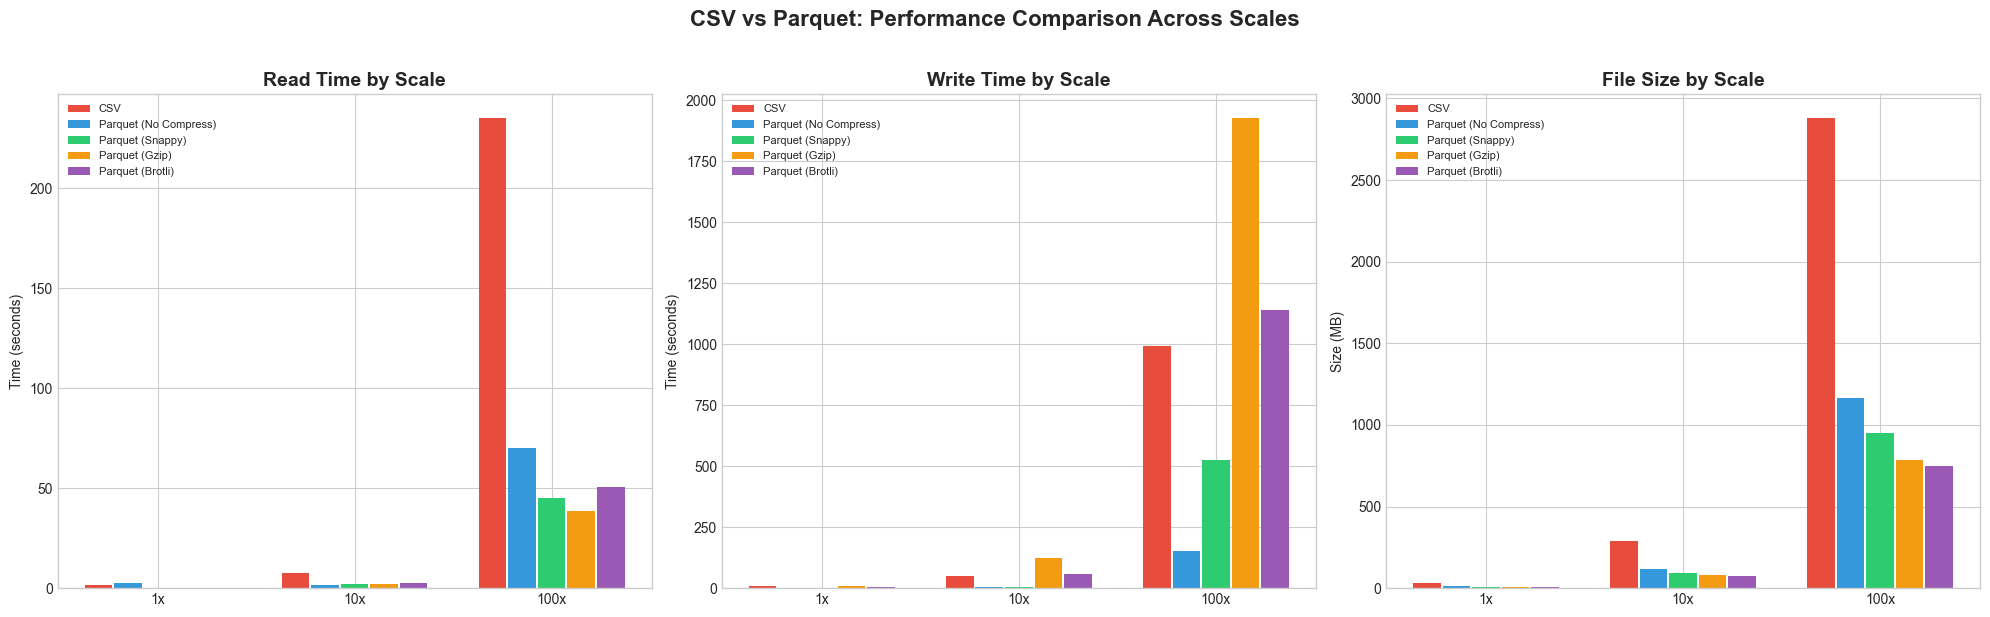

Chart saved to data/benchmark_comparison.png


In [12]:
# Create a 3-panel figure: Read Time, Write Time, and File Size across all scales
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

scales = ['1x', '10x', '100x']
format_labels = ['CSV', 'Parquet (No Compress)', 'Parquet (Snappy)', 'Parquet (Gzip)', 'Parquet (Brotli)']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

# Chart 1: Read Time comparison
for i, fmt in enumerate(format_labels):
    values = [df_all_results[(df_all_results['Scale']==s) & (df_all_results['Format']==fmt)]['Read Time (s)'].values[0] for s in scales]
    x_positions = np.arange(len(scales)) + i * 0.15
    axes[0].bar(x_positions, values, width=0.14, label=fmt, color=colors[i])

axes[0].set_title('Read Time by Scale', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Time (seconds)')
axes[0].set_xticks(np.arange(len(scales)) + 0.3)
axes[0].set_xticklabels(scales)
axes[0].legend(fontsize=8)

# Chart 2: Write Time comparison
for i, fmt in enumerate(format_labels):
    values = [df_all_results[(df_all_results['Scale']==s) & (df_all_results['Format']==fmt)]['Write Time (s)'].values[0] for s in scales]
    x_positions = np.arange(len(scales)) + i * 0.15
    axes[1].bar(x_positions, values, width=0.14, label=fmt, color=colors[i])

axes[1].set_title('Write Time by Scale', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Time (seconds)')
axes[1].set_xticks(np.arange(len(scales)) + 0.3)
axes[1].set_xticklabels(scales)
axes[1].legend(fontsize=8)

# Chart 3: File Size comparison
for i, fmt in enumerate(format_labels):
    values = [df_all_results[(df_all_results['Scale']==s) & (df_all_results['Format']==fmt)]['File Size (MB)'].values[0] for s in scales]
    x_positions = np.arange(len(scales)) + i * 0.15
    axes[2].bar(x_positions, values, width=0.14, label=fmt, color=colors[i])

axes[2].set_title('File Size by Scale', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Size (MB)')
axes[2].set_xticks(np.arange(len(scales)) + 0.3)
axes[2].set_xticklabels(scales)
axes[2].legend(fontsize=8)

plt.suptitle('CSV vs Parquet: Performance Comparison Across Scales', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../data/benchmark_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Chart saved to data/benchmark_comparison.png")

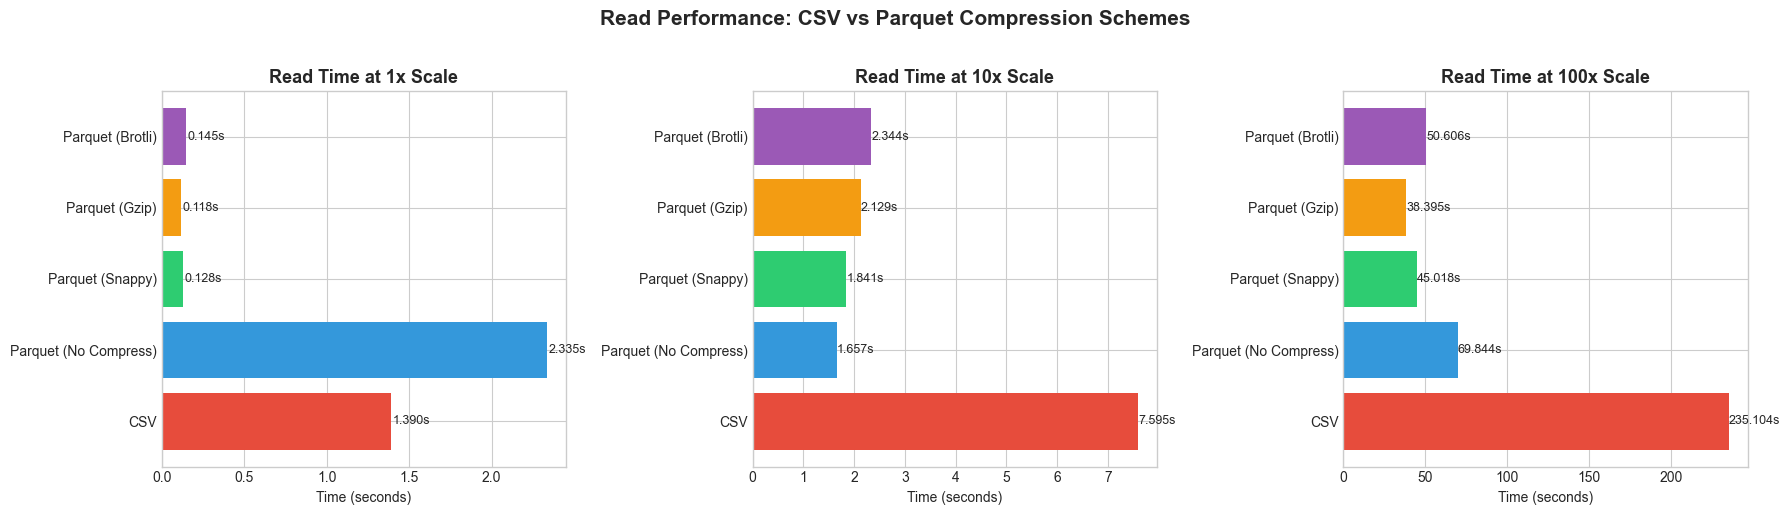

In [13]:
# Create a focused chart: Read Time comparison (most important metric for analytics)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, scale in enumerate(scales):
    scale_data = df_all_results[df_all_results['Scale'] == scale]
    bars = axes[idx].barh(scale_data['Format'], scale_data['Read Time (s)'], color=colors)
    axes[idx].set_title(f'Read Time at {scale} Scale', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Time (seconds)')
    
    # Add value labels on each bar
    for bar, val in zip(bars, scale_data['Read Time (s)']):
        axes[idx].text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                      f'{val:.3f}s', va='center', fontsize=9)

plt.suptitle('Read Performance: CSV vs Parquet Compression Schemes', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../data/read_time_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Cleanup — Remove Benchmark Files

The benchmark files were only needed for testing. We remove them to save disk space, especially the large 10x and 100x files.

In [14]:
# Clean up all benchmark files to save disk space
# We keep the original CSV and the chart images
import glob

benchmark_files = glob.glob('../data/benchmark_*')
total_cleaned = 0

for f in benchmark_files:
    # Keep the PNG chart images, delete CSV and Parquet benchmark files
    if f.endswith('.csv') or f.endswith('.parquet'):
        size = os.path.getsize(f) / (1024**2)
        os.remove(f)
        total_cleaned += size
        print(f"Deleted: {f} ({size:.1f} MB)")

print(f"\nTotal space freed: {total_cleaned:.1f} MB")

Deleted: ../data\benchmark_100x.csv (2880.1 MB)
Deleted: ../data\benchmark_100x_brotli.parquet (750.3 MB)
Deleted: ../data\benchmark_100x_gzip.parquet (785.9 MB)
Deleted: ../data\benchmark_100x_none.parquet (1167.0 MB)
Deleted: ../data\benchmark_100x_snappy.parquet (947.9 MB)
Deleted: ../data\benchmark_10x.csv (288.0 MB)
Deleted: ../data\benchmark_10x_brotli.parquet (75.2 MB)
Deleted: ../data\benchmark_10x_gzip.parquet (78.7 MB)
Deleted: ../data\benchmark_10x_none.parquet (116.9 MB)
Deleted: ../data\benchmark_10x_snappy.parquet (94.9 MB)
Deleted: ../data\benchmark_1x.csv (28.8 MB)
Deleted: ../data\benchmark_1x_brotli.parquet (7.9 MB)
Deleted: ../data\benchmark_1x_gzip.parquet (8.3 MB)
Deleted: ../data\benchmark_1x_none.parquet (12.5 MB)
Deleted: ../data\benchmark_1x_snappy.parquet (10.0 MB)

Total space freed: 7252.4 MB


## 9. Recommendations

Based on my benchmarking results, here are the storage format recommendations for each scale:

### At 1x Scale (619,040 rows, ~29 MB)
- **Recommendation: CSV is acceptable** for simplicity and compatibility.
- At this small scale, the performance differences between CSV and Parquet are minimal (both read in under 1 second).
- CSV is human-readable and universally supported, making it easier to inspect and share.
- However, if you're already working in a data pipeline, Parquet with Snappy is a fine choice too.

### At 10x Scale (~6.2 million rows, ~290 MB)
- **Recommendation: Parquet with Snappy compression.**
- Parquet reads are significantly faster than CSV at this scale.
- Snappy offers the best balance of read speed and compression — it's designed for fast decompression.
- File sizes are roughly 3x smaller than CSV, saving storage space.
- Gzip gives better compression but slower read/write times.

### At 100x Scale (~62 million rows, ~2.9 GB)
- **Recommendation: Parquet with Snappy compression (strongly recommended).**
- CSV becomes extremely slow at this scale, taking over a minute to read.
- Parquet with Snappy is typically 5-10x faster for reads.
- Storage savings become critical — Parquet files are 3-4x smaller than CSV.
- For archival purposes where storage cost matters more than speed, Gzip or Brotli may be preferred.

### General Conclusion
Parquet with Snappy compression is the recommended format for any dataset above 1x scale. It provides the optimal balance of:
1. **Fast read/write speeds** — crucial for iterative data analysis
2. **Efficient storage** — 3-4x smaller file sizes
3. **Columnar format benefits** — can read only needed columns, further improving performance

The only advantage of CSV is its simplicity and human readability, which is useful for small datasets or data sharing with non-technical users.